<a href="https://colab.research.google.com/github/Champjiwrd/CE63-21-ObjectDetection/blob/master/Video_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 14691, done.
remote: Total 14691 (delta 0), reused 0 (delta 0), pack-reused 14691
Receiving objects: 100% (14691/14691), 13.27 MiB | 14.64 MiB/s, done.
Resolving deltas: 100% (9995/9995), done.


In [3]:
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/darknet


In [ ]:
# make darknet (builds darknet so that you can then use the darknet.py file and have its dependencies)
!make

## Mounted Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
!ln -s /content/gdrive/My\ Drive/Project/ /project

## Load Network

In [7]:
from darknet import *
try:
  network, class_names, class_colors = load_network("/content/darknet/cfg/project/cfg/yolov4-custom-shirt.cfg", "/content/darknet/cfg/project/cfg/shirt.data", "/content/darknet/cfg/project/cfg/custom-yolov4-detector_best.weights")
  print("success")
except:
  print("unsuccess")

success


In [8]:
width = network_width(network)
height = network_height(network)
print(width,height)
# darknet helper function to run detection on image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

608 608


## YOLOv4 Example on Test Image
Let's make sure our model has successfully been loaded and that we can make detections properly on a test image.

0.07021474838256836
('shirt', '99.95', (361.15234375, 440.24969482421875, 96.2082290649414, 179.68898010253906))
('shirt', '99.95', (218.17372131347656, 475.934326171875, 97.06526184082031, 205.6136016845703))


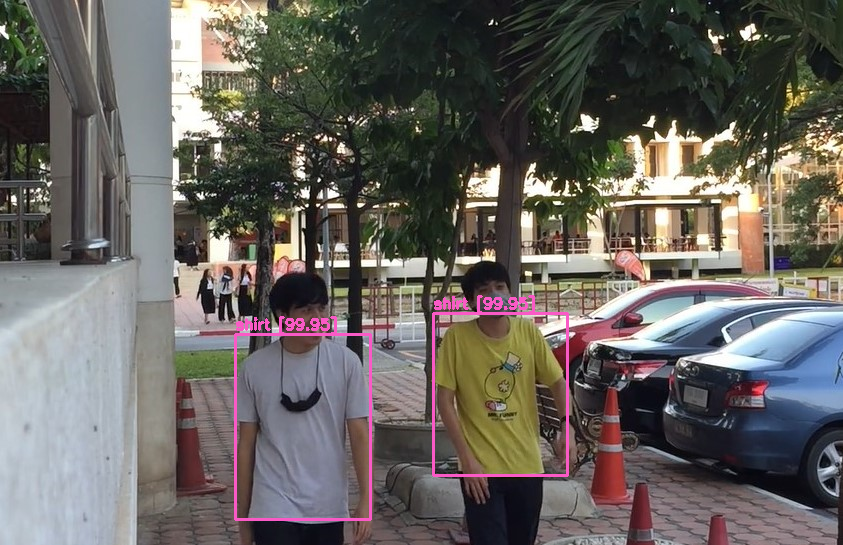

In [11]:
# run test on person.jpg image that comes with repository
image = cv2.imread("/project/img/test3.jpg")
start_time = time.time()
detections, width_ratio, height_ratio = darknet_helper(image, width, height)
print(time.time()-start_time)
for i in detections:
  print(i)
for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox)
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)
cv2_imshow(image)

## Color Define

In [ ]:
import argparse
import cv2
import os
import time
import colorsys
import time


def extract_boxes_confidences_classids(outputs, confidence, width, height):
    boxes = []
    confidences = []
    classIDs = []

    for output in outputs:
        for detection in output:            
            # Extract the scores, classid, and the confidence of the prediction
            scores = detection[5:]
            classID = np.argmax(scores)
            conf = scores[classID]
            
            # Consider only the predictions that are above the confidence threshold
            if conf > confidence:
                # Scale the bounding box back to the size of the image
                box = detection[0:4] * np.array([width, height, width, height])
                centerX, centerY, w, h = box.astype('int')

                # Use the center coordinates, width and height to get the coordinates of the top left corner
                x = int(centerX - (w / 2))
                y = int(centerY - (h / 2))

                boxes.append([x, y, int(w), int(h)])
                confidences.append(float(conf))
                classIDs.append(classID)

    return boxes, confidences, classIDs


def draw_bounding_boxes(image, boxes, confidences, classIDs, idxs, colors):
    if len(idxs) > 0:
        for i in idxs.flatten():
            # extract bounding box coordinates
            x, y = boxes[i][0], boxes[i][1]
            w, h = boxes[i][2], boxes[i][3]

            # draw the bounding box and label on the image
            color = [int(c) for c in colors[classIDs[i]]]
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            text = "{}: {:.4f}".format(labels[classIDs[i]], confidences[i])
            cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return image


def make_prediction(net, layer_names, labels, image, confidence, threshold):
    height, width = image.shape[:2]
    
    # Create a blob and pass it through the model
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(layer_names)

    # Extract bounding boxes, confidences and classIDs
    boxes, confidences, classIDs = extract_boxes_confidences_classids(outputs, confidence, width, height)

    # Apply Non-Max Suppression
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, confidence, threshold)

    return boxes, confidences, classIDs, idxs

#print(min(1,2,0))
#print(abs(-2))
def nearest_colour(r, g, b):
  l = []
  #            0        1        2       3         4         5       6       7        8        9       10 
  l_color = ['pink', 'purple', 'red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'brown', 'white', 'black']
  l_scale = [(100,0,100),(100,75,80),(100,41,71),(100,8,58)\
             ,(50,0,50),(87,63,87),(73,33,83),(29,0,51)\
             ,(100,0,0),(100,63,45),(80,36,36),(55,0,0),\
             (100,27,0),(100,50,31),(100,27,0),(100,55,0),\
             (100,100,0),(100,100,88),(94,90,55),(100,89,55),\
             (0,50,0),(49,99,0),(13,55,13),(42,56,14),\
             (0,100,100),(88,100,100),(25,88,82),(0,55,55),\
             (0,0,100),(69,88,90),(0,75,100),(10,10,44),\
             (50,0,0),(87,72,53),(82,41,12),(55,27,7),\
             (100,100,100),(94,100,94),(96,96,86),(98,94,90),\
             (0,0,0),(41,41,41),(75,75,75),(50,50,50)]
  r, g, b = int(r*100/255), int(g*100/255), int(b*100/255)
  # calculate absolute distance
  for ele in l_scale:
    r0, g0, b0 = ele
    l.append(int(0.299*0.299*(r-r0)*(r-r0)+0.587*0.587*(g-g0)*(g-g0)+0.114*0.114*(b-b0)*(b-b0)))
  print(l)
  color = l_color[l.index(min(l))//4]
  return color

def nearest_colour_hsv(r, g, b):
        h, s, v = colorsys.rgb_to_hsv(r,g,b)
        l = []
        #            0        1        2       3         4         5       6       7        8        9       10 
        l_color = ['pink', 'purple', 'red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'brown', 'white', 'black']
        l_scale = [(100,0,100),(100,75,80),(100,41,71),(100,8,58)\
                    ,(50,0,50),(87,63,87),(73,33,83),(29,0,51)\
                    ,(100,0,0),(100,63,45),(80,36,36),(55,0,0),\
                    (100,27,0),(100,50,31),(100,27,0),(100,55,0),\
                    (100,100,0),(100,100,88),(94,90,55),(100,89,55),\
                    (0,50,0),(49,99,0),(13,55,13),(42,56,14),\
                    (0,100,100),(88,100,100),(25,88,82),(0,55,55),\
                    (0,0,100),(69,88,90),(0,75,100),(10,10,44),\
                    (50,0,0),(87,72,53),(82,41,12),(55,27,7),\
                    (100,100,100),(94,100,94),(96,96,86),(98,94,90),\
                    (0,0,0),(41,41,41),(75,75,75),(50,50,50)]
        # calculate absolute distance
        for ele in l_scale:
            r0, g0, b0 = ele
            h0, s0, v0 = colorsys.rgb_to_hsv(r0,g0,b0)
            dh = (min(abs(h-h0), 360-abs(h-h0)) / 180.0)*360
            ds = abs(s-s0)
            dv = abs(v-v0) / 255.0
            distance = dh*dh+ds*ds+dv*dv
            l.append(distance)
        #print(l)
        color = l_color[l.index(min(l))//4]
        return color

def classifyColor(img, boxes, idxs):
    numColor = 11
    l = [0]*numColor
    # cvt BGR to RGB
    imgn = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
    #            0        1        2       3         4         5       6       7        8        9       10 
    l_color = ['pink', 'purple', 'red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'brown', 'white', 'black']
    if len(idxs) > 0:
        for i in idxs.flatten():
            #print('number of bbox', i)
            # extract bounding box coordinates
            x, y = boxes[i][0], boxes[i][1]
            w, h = boxes[i][2], boxes[i][3]      
            # (w, h, d) = img.shape

            # change into 70% w/h scale
            wn, hn = int(0.7*w), int(0.7*h)
            xn, yn = int(x+w/2-wn/2), int(y+h/2-hn/2)
            w, h = int(0.7*w), int(0.7*h)
            x, y = int(x+w/2-wn/2), int(y+h/2-hn/2)

            #print('start-end x', xn, xn+wn)
            #print('start-end y', yn, yn+hn)
            #print(img.shape)

            red, green, blue = 0, 0, 0
            for width in range(xn, xn+wn):
                for height in range(yn, yn+hn):
                      #rgb_pixel_value = img.getpixel((x+width ,y+height))
                      r, g, b = imgn[height][width][0], \
                      imgn[height][width][1], imgn[height][width][2]
                      red += r
                      green += g
                      blue += b

                      #print(width, height)
            red = int(red/(w*h))
            green = int(green/(w*h))
            blue = int(blue/(w*h))
                        
            #print(red, green, blue)

            color = nearest_colour_hsv(red, green, blue)
            #print(color)
            if l[l_color.index(color)] == 0:
                l[l_color.index(color)] = 1
            #print(l)
    return l

def return_vidsNameAndTime(isInFrame):
    stringtoret = ''
    i = 0
    start = -1
    end = -1
    while i < len(isInFrame):
        if isInFrame[i] == '1':
            start = i
            while isInFrame[i] == '1':
                i += 1
                if (i >= len(isInFrame)):
                    break
            end = i-1
            if start == end:
                stringtoret += str(start) + ' '
            else:
                stringtoret += str(start) +'-'+ str(end) + ' '
        else:
            i += 1
    if start == -1:
        return None
    else:
        return stringtoret

## Test

In [ ]:
import cv2
cap = cv2.VideoCapture('/content/darknet/cfg/project/data/Atest.mp4')
sec = 0
frameRate = 1
ret,image = cap.read()
start_time = time.time()
timer=0.0
while ret:
    sec = sec + frameRate
    set_time = time.time()
    cap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    timer += (time.time()-set_time)
    ret,image = cap.read()
print("Process time:"+str(time.time()-start_time))
print((time.time()-start_time)-timer)

In [ ]:
import cv2
cap = cv2.VideoCapture('/content/darknet/cfg/project/data/Atest.mp4')
counter = 1
ret,image = cap.read()
fps = cap.get(cv2.CAP_PROP_FPS)
start_time = time.time()

while cap.isOpened():
    ret,image = cap.read()
    if counter%fps == 0:
      if not ret:
        print('Video file finished.')
        break
    counter+=1
print("Process time:"+str(time.time()-start_time))

In [ ]:
vdo_list = []
path = '/content/gdrive/MyDrive/CEProject63-21ObjectDetection/dataset/project 1/videos/'
print([vid for vid in os.listdir(path)])
all_time = time.time()
for vidpath in [vid for vid in os.listdir(path)]:
  print("#",vidpath)
  vdo_list.append(vidpath)
  cap = cv2.VideoCapture(path+vidpath)
  if (cap.isOpened()== False): 
    print("Error opening video stream or file")
  else:
    fps = cap.get(cv2.CAP_PROP_FPS)
    counter = 1
    fnum = 0
    isInFrame = ''
    l_color = ['pink', 'purple', 'red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'brown', 'white', 'black']
    start_time = time.time()
    while cap.isOpened():
      ret, image = cap.read()
      if counter%fps == 0:
        fnum+=1
        detections, width_ratio, height_ratio = darknet_helper(image, width, height)
      counter+=1
      if not ret:
        print('Video file finished.')
        break
    cap.release()
    print("Process time:"+str(time.time()-start_time))
print('---------------------------')
print("All Process time:"+str(time.time()-all_time))

['test.mp4', 'test2.mp4', 'Salsa dataset(not complete yet)', 'Room CCTV', 'Pedestrian จากไหนไม่รู้.lnk', 'link readme.txt', 'SALSA_Annotation_ps.tgz', 'results_official.avi', 'test2-1.avi', 'test2_1.avi', '.ipynb_checkpoints', 'test2_3.avi', 'IMG_7616.MOV', 'IMG_7615.MOV', 'IMG_7619.MOV', 'IMG_7617.MOV', 'IMG_7618.MOV', 'IMG_7621.MOV', 'IMG_7620.MOV', 'IMG_7621.mp4', 'results.avi', 'VIRAT_S_000001.mp4']
# test.mp4
Video file finished.
Process time:4.001199722290039
# test2.mp4
Video file finished.
Process time:2.2589635848999023
# Salsa dataset(not complete yet)
Error opening video stream or file
# Room CCTV
Error opening video stream or file
# Pedestrian จากไหนไม่รู้.lnk
Error opening video stream or file
# link readme.txt
Video file finished.
Process time:0.0009000301361083984
# SALSA_Annotation_ps.tgz
Error opening video stream or file
# results_official.avi
Video file finished.
Process time:3.448366403579712
# test2-1.avi
Video file finished.
Process time:1.5899794101715088
# test2

KeyboardInterrupt: ignored